<a href="https://colab.research.google.com/github/jhyeon-kim/ai_study/blob/main/01_%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5036075.15it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 65642.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1261572.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5063936.41it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


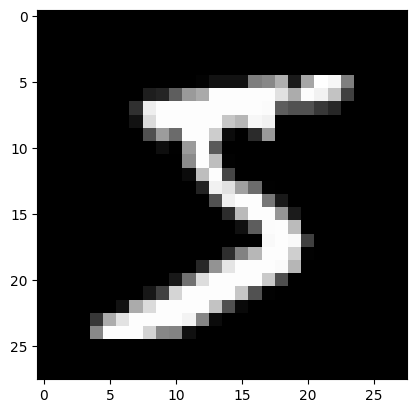

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [4]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [6]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 1)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [7]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [ ]:
n_epochs = 100

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = (preds[:, 0] - labels).pow(2).mean()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 4609.736693739891
Epoch   1 | Loss: 2522.893892765045
Epoch   2 | Loss: 1807.6151924729347
Epoch   3 | Loss: 1422.2451617121696
Epoch   4 | Loss: 1195.491718918085
Epoch   5 | Loss: 1053.6574390232563
Epoch   6 | Loss: 952.1634658575058
Epoch   7 | Loss: 879.042916238308
Epoch   8 | Loss: 818.7386544644833
Epoch   9 | Loss: 771.1778815686703
Epoch  10 | Loss: 729.5409344732761
Epoch  11 | Loss: 693.3726135194302
Epoch  12 | Loss: 660.9100622683764
Epoch  13 | Loss: 631.16512799263
Epoch  14 | Loss: 605.9077615588903
Epoch  15 | Loss: 580.5695589482784
Epoch  16 | Loss: 559.1079169213772
Epoch  17 | Loss: 541.1392047703266
Epoch  18 | Loss: 519.3692178875208
Epoch  19 | Loss: 500.82538667321205
Epoch  20 | Loss: 484.6212624460459
Epoch  21 | Loss: 470.3438350260258
Epoch  22 | Loss: 456.8827604204416
Epoch  23 | Loss: 441.1874012351036
Epoch  24 | Loss: 427.9177328199148
Epoch  25 | Loss: 418.84781112521887
Epoch  26 | Loss: 403.242155469954
Epoch  27 | Loss: 395.31427

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [ ]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[4.6796]], device='cuda:0', grad_fn=<ReluBackward0>)
5


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

# 기본과제


- [x]  Test data 준비하기
    - Test data는 MNIST의 train data를 load하는 코드에서 `train=False`로 두면 됩니다.
    - Train data와 마찬가지로 test data에 대한 data loader를 생성해주시면 됩니다(batch size는 동일하게 적용).
        - Test data는 랜덤하게 섞일 필요가 없기 때문에 `shuffle=False`로 설정합니다.

In [8]:
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

- [x]  `nn.CrossEntropyLoss` 적용하기
    - 현재 코드는 regression model을 구현한 상태로, MSE를 loss로 사용하고 있습니다.
    - 하지만 MNIST와 같은 분류 문제에서는 MSE는 적합하지 않습니다.
        - MSE에 따르면 1에 해당하는 손글씨 이미지는 7에 해당하는 손글씨 이미지보다 0에 해당하는 손글씨 이미지가 더 가깝게 여겨집니다.
        - 하지만 1은 실제로 0보다 7과 더 비슷하게 생겼습니다.
    - 일반적으로 분류 문제는 MSE 대신 cross entropy loss를 사용합니다.
    - PyTorch에서의 [cross entropy loss 문서](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) 또는 [웹 자료](https://uumini.tistory.com/54)들을 통해 이해한 후, MSE를 대체하는 코드를 구현하시면 됩니다.
        - 변경되어야 할 점은 2가지로 i) `Model`의 최종 output의 dimension과 ii) `loss` 계산 부분입니다.

In [9]:
# 1. 모델의 출력 차원 변경

from torch import nn

class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # 0 ~ 9 까지의 숫자로 분류할 것이므로, 분류할 클래스 수는 10

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

model_2 = Model(28 * 28 * 1, 1024)
# Q. 은닉층의 차원은 1024 로 하는 것이 적절한 이유가 있을까?

In [11]:
from torch.optim import SGD

lr = 0.001
model_2 = model_2.to('cuda')

# optimizer 선택
optimizer = SGD(model_2.parameters(), lr=lr)

# 손실함수 선택
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss 는 내부적으로 softmax 로 변환하는 과정을 포함

n_epochs = 100

for epoch in range(n_epochs):

  total_loss = 0.
  for data in trainloader:
    model_2.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_2(inputs)
    loss = criterion(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 2129.6247897148132
Epoch   1 | Loss: 2057.4296646118164
Epoch   2 | Loss: 1939.3110617399216
Epoch   3 | Loss: 1735.7920867204666
Epoch   4 | Loss: 1438.385588645935
Epoch   5 | Loss: 1128.7175089716911
Epoch   6 | Loss: 898.3891317844391
Epoch   7 | Loss: 749.6204717159271
Epoch   8 | Loss: 652.2938196361065
Epoch   9 | Loss: 584.740715354681
Epoch  10 | Loss: 535.6166769862175
Epoch  11 | Loss: 498.2350735962391
Epoch  12 | Loss: 468.79651510715485
Epoch  13 | Loss: 444.9579499512911
Epoch  14 | Loss: 425.48983094096184
Epoch  15 | Loss: 409.267250880599
Epoch  16 | Loss: 395.4759897887707
Epoch  17 | Loss: 383.56817977130413
Epoch  18 | Loss: 373.23099306225777
Epoch  19 | Loss: 364.2816619873047
Epoch  20 | Loss: 356.1275096833706
Epoch  21 | Loss: 348.96450117230415
Epoch  22 | Loss: 342.4804094135761
Epoch  23 | Loss: 336.6176057755947
Epoch  24 | Loss: 331.29969008266926
Epoch  25 | Loss: 326.26980759203434
Epoch  26 | Loss: 321.4680659994483
Epoch  27 | Loss: 

- [x]  학습을 진행한 후, epoch에 따른 model의 train과 test data에 대한 정확도 plot하기
    - 다음 조건들 아래에서 학습을 진행하면 됩니다.
        - `n_epochs`=100, `batch_size`=256, `lr`=0.001.
    - 어떤 dataloader에 대한 model의 정확도를 측정하는 코드는 다음 함수를 사용하시면 됩니다:
        
        ```python
        def accuracy(model, dataloader):
          cnt = 0
          acc = 0
        
          for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)
        
            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()
        
          return acc / cnt
        ```
        
    - 추가적으로 구현되어야 하는 부분들을 요약하면 다음과 같습니다:
        - 매 epoch가 끝난 뒤의 model의 `trainloader`와 `testloader`에 대한 정확도를 각각 list로 저장해둡니다.
        - Epoch에 따른 train과 test data에 대한 model의 정확도를 다음 코드를 사용하여 plot합니다:
            
            ```python
            def plot_acc(train_accs, test_accs, label1='train', label2='test'):
              x = np.arange(len(train_accs))
            
              plt.plot(x, train_accs, label=label1)
              plt.plot(x, test_accs, label=label2)
              plt.legend()
              plt.show()
            ```

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 학습을 위한 파라미터 설정
n_epochs = 100
batch_size = 256
lr = 0.001

# Dataloader 설정 (batch size 변경된 것으로 반영!)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 손실함수, 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=lr)

# 정확도 측정 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  model.eval() # 평가모드로 변경 -> dropout, batchnorm 과 같은 동작을 사용하지 않도록
  with torch.no_grad(): # gradient 계산을 할 필요 없으므로 비활성화 (리소스 절약)
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=-1) # 각 샘플에 대해 가장 높은 점수를 가진 클래스의 인덱스를 반환하는 함수

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item() # label 대로 정확히 맞춘 개수

    model.train()
    return acc / cnt

# 정확도 플롯 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()



Epoch:   1/100 | Loss: 32.7662 | Train Acc: 0.9605 | Test Acc: 0.9576
Epoch:   2/100 | Loss: 32.7272 | Train Acc: 0.9606 | Test Acc: 0.9576
Epoch:   3/100 | Loss: 32.6904 | Train Acc: 0.9606 | Test Acc: 0.9577
Epoch:   4/100 | Loss: 32.5854 | Train Acc: 0.9606 | Test Acc: 0.9577
Epoch:   5/100 | Loss: 32.5503 | Train Acc: 0.9608 | Test Acc: 0.9578
Epoch:   6/100 | Loss: 32.5534 | Train Acc: 0.9608 | Test Acc: 0.9578
Epoch:   7/100 | Loss: 32.4714 | Train Acc: 0.9609 | Test Acc: 0.9580
Epoch:   8/100 | Loss: 32.4285 | Train Acc: 0.9609 | Test Acc: 0.9580
Epoch:   9/100 | Loss: 32.4420 | Train Acc: 0.9609 | Test Acc: 0.9578
Epoch:  10/100 | Loss: 32.3817 | Train Acc: 0.9609 | Test Acc: 0.9580
Epoch:  11/100 | Loss: 32.3705 | Train Acc: 0.9611 | Test Acc: 0.9580
Epoch:  12/100 | Loss: 32.2560 | Train Acc: 0.9612 | Test Acc: 0.9578
Epoch:  13/100 | Loss: 32.1986 | Train Acc: 0.9612 | Test Acc: 0.9581
Epoch:  14/100 | Loss: 32.1588 | Train Acc: 0.9612 | Test Acc: 0.9580
Epoch:  15/100 | Los

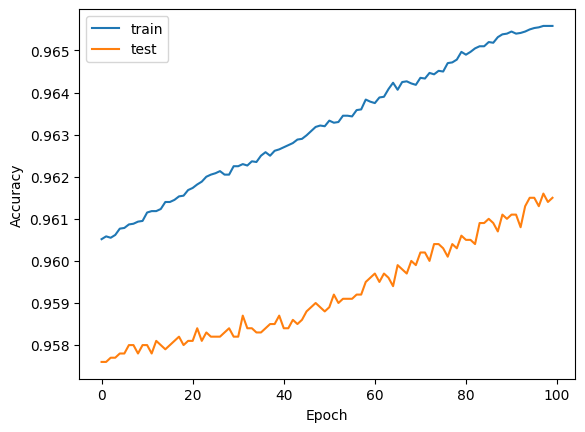

In [20]:
# 정확도를 저장할 리스트
train_accs = []
test_accs = []

# 매 epoch 마다 train, test 에 대해 정확도 측정
for epoch in range(n_epochs):
  total_loss = 0.

  for data in trainloader:
    model_2.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_2(inputs)
    loss = criterion(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_acc = accuracy(model_2, trainloader)
  test_acc = accuracy(model_2, testloader)

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch: {epoch+1:3d}/{n_epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

# 정확도 플롯 그리기
plot_acc(train_accs, test_accs)
